# Numerical Solutions of Partial Differential Equations

Calculus, particularly Partial Differential Equations (PDEs), has been a cornerstone of mathematical modeling in engineering and science. Over the past century, the theoretical study of PDEs has achieved remarkable success, advancing our understanding of complex phenomena. However, as the demand for precise and detailed quantitative solutions grows, alternative tools have become necessary to meet the needs of practitioners.

The advent of modern computing in the 1950s revolutionized the field, making the numerical simulation of PDEs a feasible and practical approach. Over the last 70 years, a wide range of algorithms has been developed for this purpose, offering speed, robustness, and accuracy. Key methods include:

1. Finite Difference Methods
2. Finite Element Methods
3. Spectral Element Methods
4. Boundary Integral/Element Methods

Despite significant achievements in creating robust and adaptable solvers for a wide variety of problems, the pursuit of faster, more efficient techniques remains ongoing. Recently, practitioners have begun exploring machine learning-based solvers as a promising new approach to tackle increasingly complex and subtle challenges in the field.

# Physics-Informed Neural Networks

The material and images in this section are influenced by material in Ben Moseley's [blog](https://benmoseley.blog/).

Machine learning is gaining traction in scientific disciplines, but can these algorithms truly “understand” the scientific problems they aim to solve? This notebook provides a brief overview of physics-informed neural networks (PINNs), a powerful technique that integrates physical laws into machine learning models, thereby combining empirical data with scientific principles.


## Machine Learning in Science

Machine learning has brought about a paradigm shift in scientific methodology. Traditionally, scientific research has relied on the iterative refinement of theories through experimental data. In this approach, a well-defined theoretical model is tested and modified as new experimental results emerge, guiding further predictions.

With the rapid development of machine learning technologies and the increasing availability of data, data-driven approaches have become prevalent. In this framework, a pre-existing theory is not a prerequisite. Instead, machine learning algorithms are trained on data to analyze a scientific problem without explicit reliance on theoretical constructs.


## Learning to model experimental data

One way in which machine learning can be applied in scientific research is by modeling experimental data. Consider an example where experimental data points represent an unknown physical phenomenon, such as the orange points in the animation below.

![](https://benmoseley.blog/wp-content/uploads/2021/08/nn.gif)

A popular method for this task is the use of a neural network. Given the position of a data point $x$, a neural network can be used to predict its corresponding value $u$, as illustrated in the figure below.

![size=0.7](https://benmoseley.blog/wp-content/uploads/2021/08/nn.png)

To train the network, its free parameters $(\theta_j)$ are adjusted so that the predictions closely align with the provided data. This is typically achieved by minimizing the mean squared error (MSE) between the network's predictions and the true data values:

$$ \underset{\text{Mean-Square Error}}{\min \underbrace{\frac{1}{N}\sum_i^N \left(u_{NN}(x_i;\theta) - u_{\text{true}}(x_i)\right)^2}}. $$

After training, the network can fit the experimental data, as shown in the animation.

## Limitations of purely data-driven approaches

While data-driven methods can be effective within the range of available data, they often struggle to generalize beyond the training data. For example, in the animation above, the grey line represents the actual values of the physical process that generated the experimental data. It is evident that the neural network performs well near the training data but fails to capture the true behavior of the system in regions without data. This limitation reveals that a purely data-driven approach may not fully capture the underlying scientific phenomena.


## The rise of scientific machine learning (SciML)

Now, consider that we have prior knowledge about the physical process governing the data. Specifically, the data points correspond to the position of a damped harmonic oscillator, a well-known problem in physics.

![](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif)

The dynamics of this system can be described by the following second-order differential equation:

$$ m\frac{d^2 u}{dx^2} + \mu \frac{du}{dx} + ku = 0 $$

where $m$ represents the mass of the oscillator, $\mu$ is the damping coefficient, and $k$ is the spring constant. Recognizing the limitations of purely data-driven models, researchers are now integrating such prior scientific knowledge into machine learning workflows, leading to the development of scientific machine learning (SciML) approaches. These approaches aim to combine data with well-established physical principles.


## So, what exactly is a physics-informed neural network?

A *physics-informed neural network (PINN)* provides a way to incorporate known physical laws, such as differential equations, directly into the neural network's training process. The concept is straightforward: in addition to minimizing the error between predictions and data, we also introduce the governing physical equations into the network's loss function.

The process begins by sampling a set of input locations ($x_j$) and passing them through the neural network. The gradients of the network's output with respect to its inputs are computed (using techniques such as [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)), and these gradients are used to calculate the residuals of the differential equation. This residual is then added to the loss function as a *physics-based regularization term*.

![size=0.8](https://benmoseley.blog/wp-content/uploads/2021/08/pinn.png)

For the damped harmonic oscillator, this leads to a loss function of the form:

$$ \underset{\text{Mean-Square Error}}{\min \underbrace{\frac{1}{N}\sum_i^N \left(u_{NN}(x_i;\theta) - u_{\text{true}}(x_i)\right)^2}} + \underset{\text{Physical Loss}}{\underbrace{\frac{1}{M}\sum_j^M \left(\left[m\frac{d}{dx^2} + \mu \frac{d}{dx} + k\right]u_{NN}(x_j;\theta)\right)^2}} $$

This additional term ensures that the neural network's learned solution adheres to the physical constraints imposed by the known differential equation.

## Remarks

By incorporating physical laws into the training process, PINNs can generalize better to regions where no data is available, as demonstrated in the case of the damped harmonic oscillator. The physics-informed model is capable of accurately predicting the system's behavior far from the experimental data points, outperforming purely data-driven models.

The poor performance of the naive network can be attributed to its reliance on data alone, effectively ignoring the wealth of existing scientific knowledge. In contrast, the PINN leverages this knowledge, leading to superior predictive accuracy.

PINNs are broadly applicable to any problem governed by differential equations, making them a versatile tool in scientific machine learning. For more information, one can explore the growing field of [scientific machine learning (SciML)](https://www.osti.gov/biblio/1478744) and the role of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) in neural network training.


# 1D Example

Suppose we are given the Boundary Value Problem:

 $$\begin{cases}
 \dfrac {dy} {dt} + 0.1 y - \sin\left(\dfrac{\pi t}{2}\right) = 0,& ~\text{in}~ \Omega \times (0,\infty) \\
 y(0)=1,& ~\text{on}~ \partial \Omega \times \{t=0\}
 \end{cases}$$

where $\Omega \subset \mathbb R$ is bounded. We will first setup our environment.

In [1]:
%%capture
!conda create -n pinn python=3
!conda activate pinn
!conda install jupyter numpy matplotlib
!conda install pytorch torchvision torchaudio -c pytorch
!pip install ipywidgets

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets
import pylab as pl
from IPython import display
from IPython.display import clear_output

In [3]:
def oscillatorb():
    """
    Simulates a damped oscillator using a second-order trapezoidal integration scheme.

    The oscillator is simulated over a time interval [0, 30] with damping and sinusoidal forcing.
    The integration is done using a time step determined by the number of steps specified (3000).

    Returns
    -------
    tPoints : torch.Tensor
        Time points for the simulation (shape: [n_steps, 1]).
    y : torch.Tensor
        State variable (displacement) at each time step (shape: [n_steps, 1]).
    """
    nSteps=3000              # Number of time steps
    tMin,tMax = 0.0,30.0      # Time domain
    tStep = (tMax-tMin)/nSteps   # Time step
    tPoints = np.arange(tMin, tMax, tStep) # Array of time points

    # Set initial conditions for the state variables
    y0 = 1.0
    y = [y0] # Initialize displacement

    # Solve forward in time
    for t in tPoints[1:]:
        tdemi= t - tStep/2 # Midpoint time
        # Estimate the value of y at the midpoint using the previous state
        ydemi = y[-1] + tStep/2*( - 0.1*y[-1] + np.sin(np.pi*tdemi/2))
        # Compute the next state using the midpoint estimate
        y.append(y[-1] + tStep * (- 0.1*ydemi + np.sin(np.pi*t/2)))

    y = torch.Tensor(y)

    return torch.Tensor(tPoints).view(-1, 1), torch.Tensor(y).view(-1, 1)


class FCN(nn.Module):
    """
    Fully Connected Neural Network (FCN).

    Parameters
    ----------
    N_INPUT : int
        The number of input features.
    N_OUTPUT : int
        The number of output features.
    N_HIDDEN : int
        The number of hidden units per layer.
    N_LAYERS : int
        The number of hidden layers in the network.
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        # First fully connected layer with input and hidden units
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        # Stack of hidden layers
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor.

        Returns
        -------
        torch.Tensor
            Output tensor after passing through the network.
        """
        x = self.fcs(x) # Apply the first layer
        x = self.fch(x) # Pass through the hidden layers
        x = self.fce(x) # Output layer
        return x

Then we will generate training data.

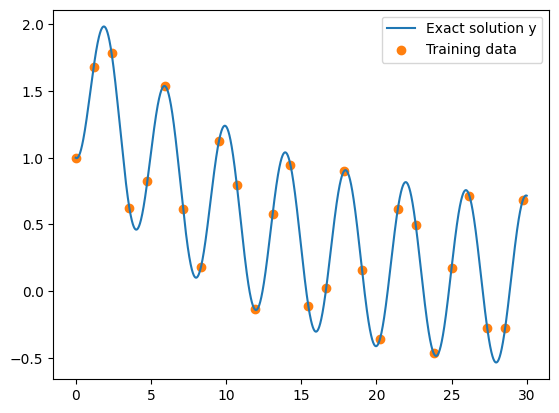

In [4]:
# Exact solution and training data
x, y = oscillatorb()
x = x[::1]
y = y[::1]
x_data=x[0:3000:119]
y_data=y[0:3000:119]


plt.figure()
plt.plot(x, y, label="Exact solution y")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

Next, let's try using a fully connected neural network to fit the training points. We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

In [5]:
# First training setup with FCN
def plot_result_NN(x, y, x_data, y_data, yh, step=None):
    """
    Plots the training results of the neural network against the exact solution.

    Parameters
    ----------
    x : array-like
        Time points for the solution (shape: [n_points, 1]).
    y : array-like
        Exact solution at each time point (shape: [n_points, 1]).
    x_data : array-like
        Time points for the training data (shape: [n_data_points, 1]).
    y_data : array-like
        Training data values (shape: [n_data_points, 1]).
    yh : array-like
        Neural network prediction at each time point (shape: [n_points, 1]).
    step : int, optional
        Current training step (default is None).
    """
    plt.figure(figsize=(8, 4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x, y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if step is not None:
        plt.text(2.965, 1.90, f"Training step: {step}", fontsize="xx-large", color="k")
    plt.legend(loc=(0.67, 0.62), frameon=False, fontsize="large")
    plt.ylabel('y', fontsize="xx-large")
    plt.xlabel('Time', fontsize="xx-large")
    plt.axis("on")

# Function to update plot based on the slider value for NN
def update_plot_NN(step):
    """
    This function clears the current figure and updates the plot with the
    corresponding prediction at the specified training step.

    Parameters
    ----------
    step : int
        The current step number to update the plot.
    """
    plt.clf()  # Clear the current figure
    yh = predictionsNN[step // 5000][1]  # Get the prediction for the current step
    plot_result_NN(x, y, x_data, y_data, yh, step=step)
    plt.show()

# Training setup
torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

# Store loss and prediction history
lossNN_history = []
predictionsNN = []

for i in range(40000):
    optimizer.zero_grad() # Zero out the gradients
    yh = model(x_data)

     # Compute the loss using mean squared error
    loss = torch.mean((yh - y_data) ** 2)
    loss.backward() # Backpropagate the loss
    optimizer.step() # Update the model parameters

    # Store loss every 100 iterations and predictions every 5000 iterations
    if (i + 1) % 100 == 0:
        lossNN_history.append(loss.detach())
        if (i + 1) % 5000 == 0:
            predictionsNN.append((i + 1, model(x).detach().numpy()))

# Create a slider for playback with increments of 5000
steps = [step for step, _ in predictionsNN]  # Extract step numbers
slider = widgets.IntSlider(value=0, min=0, max=len(predictionsNN) * 5000 - 1, step=5000, description='Training step')
widgets.interactive(update_plot_NN, step=slider)

interactive(children=(IntSlider(value=0, description='Training step', max=39999, step=5000), Output()), _dom_c…

We also examine the training loss.

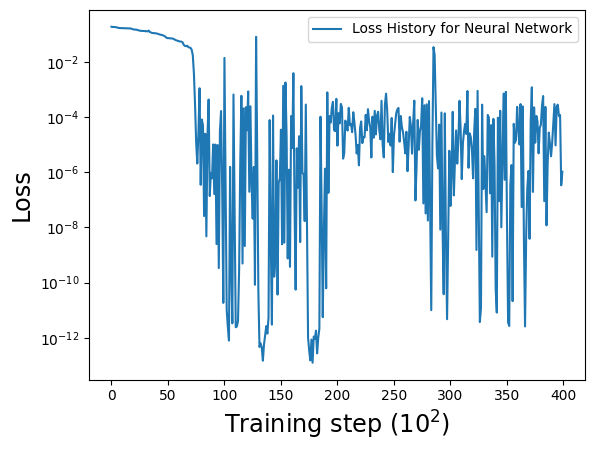

In [6]:
fig11 = plt.figure()
plt.plot(lossNN_history, label='Loss History for Neural Network')
plt.xlabel('Training step ($10^2$)', fontsize="xx-large")
plt.ylabel('Loss', fontsize="xx-large")
plt.yscale('log')
plt.legend()
plt.show()

Next, let's do the same procedure with a PINN. The physical loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

In [9]:
# Second training setup with collocation points
def plot_result_collocation(x, y, x_data, y_data, yh, xp=None, step=None):
    """
    Plots the training results for the neural network when using collocation points.

    Parameters
    ----------
    x : array-like
        Time points for the exact and predicted solutions (shape: [n_points, 1]).
    y : array-like
        Exact solution values at each time point (shape: [n_points, 1]).
    x_data : array-like
        Time points for the training data (shape: [n_data_points, 1]).
    y_data : array-like
        Training data values at each time point (shape: [n_data_points, 1]).
    yh : array-like
        Neural network predicted solution at each time point (shape: [n_points, 1]).
    xp : array-like, optional
        Collocation points used in the training (shape: [n_collocation_points, 1]).
    step : int, optional
        Current training step to be displayed on the plot (default is None).
    """
    plt.figure(figsize=(8, 4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x, y, color="blue", linewidth=2, alpha=0.8, linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0 * torch.ones_like(xp), s=30, color="tab:green", alpha=0.4,
                    label='Collocation points')
    leg = plt.legend(loc=(0.67, 0.62), frameon=False, fontsize="large")
    plt.setp(leg.get_texts(), color="k")
    plt.xlim(-1.25, 31.05)
    plt.ylim(-0.65, 2.25)
    if step is not None:
        plt.text(2.965, 1.90, f"Training step: {step}", fontsize="xx-large", color="k")
    plt.ylabel('y', fontsize="xx-large")
    plt.xlabel('Time', fontsize="xx-large")
    plt.axis("on")

def update_plot_collocation(step):
    """
    Updates the plot based on the current training step of the collocation point
    method.

    Parameters
    ----------
    step : int
        The current training step to be visualized.
    """
    plt.clf()  # Clear the current figure
    step_index = step // 5000
    if step_index < len(predictions):
        _, yh, xp = predictions[step_index]  # Get prediction and collocation points
        plot_result_collocation(x, y, x_data, y_data, yh, xp, step=step)
        plt.show()

# Collocation training setup
col_pts = torch.linspace(0, 30, 50).view(-1, 1).requires_grad_(True)  # Sample locations over the domain
lam = 0.1

# Store loss history and predictions
loss_history = []
loss2_history = []
predictions = []

for i in range(40000):
    optimizer.zero_grad() # Zero out the gradients

    # Compute the data loss (MSE between predicted and actual data)
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data) ** 2)  # Use mean squared error

    # Compute the physical loss (PDE residual)
    yhp = model(col_pts)
    dx = torch.autograd.grad(yhp, col_pts, torch.ones_like(yhp), create_graph=True)[0]
    residual = (dx + lam * yhp - torch.sin(np.pi * col_pts / 2))
    loss2 = (6e-2) * (torch.mean(residual ** 2))

    # Combine the data and physical loss
    loss = loss1 + loss2 # Total loss = data loss + physical loss
    loss.backward() # Backpropagate the total loss
    optimizer.step() # Update the model parameters

    # Store loss every 100 iterations and predictions every 5000 iterations
    if (i + 1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())

        if (i + 1) % 5000 == 0:
            yh = model(x).detach()
            xp = col_pts.detach()
            predictions.append((i + 1, yh, xp))

# Create a slider for playback with increments of 5000
slider2 = widgets.IntSlider(value=0, min=0, max=len(predictions) * 5000 - 1, step=5000, description='Training step')
widgets.interactive(update_plot_collocation, step=slider2)

interactive(children=(IntSlider(value=0, description='Training step', max=39999, step=5000), Output()), _dom_c…

We then examine the training loss from the data loss and physical loss.

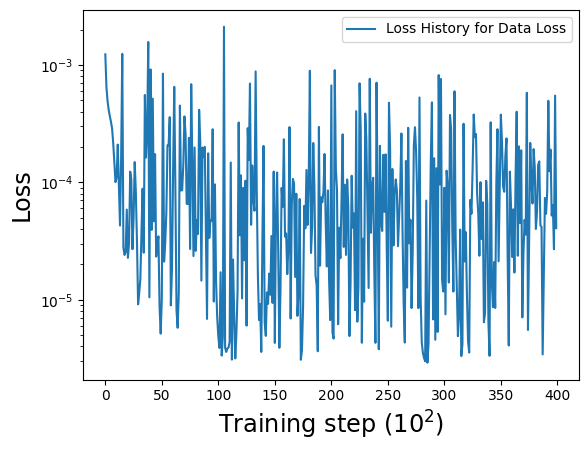

In [10]:
fig12 = plt.figure()
plt.plot(loss_history, label='Loss History for Data Loss')
plt.xlabel('Training step ($10^2$)', fontsize="xx-large")
plt.ylabel('Loss', fontsize="xx-large")
plt.yscale('log')
plt.legend()
plt.show()

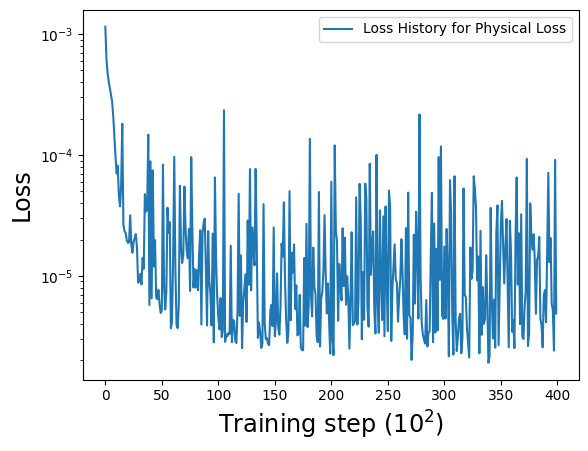

In [11]:
fig13 = plt.figure()
plt.plot(loss2_history, label="Loss History for Physical Loss")
plt.xlabel('Training step ($10^2$)', fontsize="xx-large")
plt.ylabel('Loss', fontsize="xx-large")
plt.yscale('log')
plt.legend()
plt.show()

# 2D Example

We now examine the 2D Helmholtz Boundary Value Problem:

 $$\begin{cases}
 \Delta u + k^2 u = 0, &~\text{in} ~\tilde{\Omega}\times (0,\infty) \\
 u(x,0)=g(x), &~\text{on}~\partial\tilde{\Omega}\times\{t=0\}
 \end{cases}$$

 where $x=(x_1,x_2)\in\mathbb R^2$, $~\tilde{\Omega}\subset\mathbb R^2$, and $k$ is the wave number.